In [ ]:
# %%

# Use Google Colab
use_google_colab = False
# Process the training dataset
training_data_processing = False
# Train the model
model_training = True
# Validation the model
model_validation = True
# Load the model from your Google Drive or local file system
model_loading = False

import numpy as np
import torch

from util.cuda import cuda
from util.gpu_info import gpuInfo
from util.data_augmentation import training_data_loading, training_data_augmentation
from util.loss import BCEIoULoss
from util.training import train
from util.testing import submission_creating, test

from networks.LinkNetB7 import *
from networks.DLinkNet34 import *
from networks.DLinkNet50 import *
from networks.DLinkNet101 import *
from networks.LinkNet34 import *
from networks.UNet import *


path_training = "./training/"
path_testing = "./test/"
path_data = "./data/"
path_model = "./models/DLinkNet50.model"

cuda_available = torch.cuda.is_available()
if cuda_available:
    print("CUDA is available. Utilize GPUs for computation")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Utilize CPUs for computation.")
    device = torch.device("cpu")

gpu_info = gpuInfo()

model = DLinkNet50()

if cuda_available:
    model.cuda()
print(model)

CUDA is available. Utilize GPUs for computation
Thu Nov  7 15:31:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080        Off |   00000000:01:00.0  On |                  N/A |
|  0%   43C    P8             12W /  340W |     579MiB /  16376MiB |     14%      Default |
|                                         |                        |                  N/A |


/home/wesley/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wesley/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DLinkNet50(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [ ]:
# %%

# The resolution of resized training images and the corresponding masks
training_resize = 512
# The number of resized training pairs used for data augmentation
training_number = 367
# The resolution of resized testing images
testing_resize = int(608 * training_resize / 400)
if testing_resize % 2 == 1:
    testing_resize += 1

if training_data_processing:
    # Load and generate the resized training dataset and validation dataset
    images_training, labels_training, images_validation, labels_validation = (
        training_data_loading(path_training, training_resize, training_number)
    )
    # Generate the augmented training dataset
    rotations = [0, 45, 90, 135]  # the rotation angle

    flips = ["original", np.flipud, np.fliplr]  # 'original', np.flipud, np.fliplr

    shifts = [(-16, 16)]

    images_augmented, labels_augmented = training_data_augmentation(
        images_training, labels_training, rotations, flips, shifts, training_resize
    )
    # Save the augmented training dataset and resized validation dataset
    # to your Google Drive or local file system
    np.save(f"{path_data}images_training", images_augmented)
    np.save(f"{path_data}labels_training", labels_augmented)
    np.save(f"{path_data}images_validation", images_validation)
    np.save(f"{path_data}labels_validation", labels_validation)
elif not model_loading:
    # Load the augmented training dataset and resized validation dataset
    # from your Google Drive or local file system
    images_augmented = np.load(f"{path_data}images_training.npy")
    labels_augmented = np.load(f"{path_data}labels_training.npy")
    images_validation = np.load(f"{path_data}images_validation.npy")
    labels_validation = np.load(f"{path_data}labels_validation.npy")

if model_training:
    print(f"\nimages_training.shape = {images_augmented.shape}")
    print(f"labels_training.shape = {labels_augmented.shape}")
    print(f"images_validation.shape = {images_validation.shape}")
    print(f"labels_validation.shape = {labels_validation.shape}")


images_training.shape = (6264, 3, 512, 512)
labels_training.shape = (6264, 1, 512, 512)
images_validation.shape = (224, 3, 512, 512)
labels_validation.shape = (224, 1, 512, 512)


/home/wesley/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


---------Training for Epoch 1 starting:---------
→ Running_loss for Batch 1: 0.39519888162612915
→ ACC for Batch 1: 0.9117393493652344
→ Running_loss for Batch 21: 0.3750517964363098
→ ACC for Batch 21: 0.9823036193847656
→ Running_loss for Batch 41: 0.3223854899406433
→ ACC for Batch 41: 0.9744300842285156
→ Running_loss for Batch 61: 0.29497477412223816
→ ACC for Batch 61: 0.9767475128173828
→ Running_loss for Batch 81: 0.29752713441848755
→ ACC for Batch 81: 0.9653453826904297
→ Running_loss for Batch 101: 0.23375624418258667
→ ACC for Batch 101: 0.9750165939331055
→ Running_loss for Batch 121: 0.20016571879386902
→ ACC for Batch 121: 0.9590616226196289
→ Running_loss for Batch 141: 0.236472949385643
→ ACC for Batch 141: 0.9829816818237305
→ Running_loss for Batch 161: 0.24167582392692566
→ ACC for Batch 161: 0.9729423522949219
→ Running_loss for Batch 181: 0.1807025969028473
→ ACC for Batch 181: 0.9769430160522461
→ Running_loss for Batch 201: 0.2505643665790558
→ ACC for Batch 20

  5%|▌         | 1/20 [13:20<4:13:35, 800.80s/it]


---------Training for Epoch 2 starting:---------
→ Running_loss for Batch 1: 0.16568376123905182
→ ACC for Batch 1: 0.9937143325805664
→ Running_loss for Batch 21: 0.16189661622047424
→ ACC for Batch 21: 0.9844903945922852
→ Running_loss for Batch 41: 0.17262308299541473
→ ACC for Batch 41: 0.9858522415161133
→ Running_loss for Batch 61: 0.16351307928562164
→ ACC for Batch 61: 0.980839729309082
→ Running_loss for Batch 81: 0.16202610731124878
→ ACC for Batch 81: 0.9753494262695312
→ Running_loss for Batch 101: 0.16360031068325043
→ ACC for Batch 101: 0.974858283996582
→ Running_loss for Batch 121: 0.17314252257347107
→ ACC for Batch 121: 0.9903688430786133
→ Running_loss for Batch 141: 0.21195358037948608
→ ACC for Batch 141: 0.9698963165283203
→ Running_loss for Batch 161: 0.16440151631832123
→ ACC for Batch 161: 0.9901313781738281
→ Running_loss for Batch 181: 0.18041189014911652
→ ACC for Batch 181: 0.9764938354492188
→ Running_loss for Batch 201: 0.14758563041687012
→ ACC for Batc

 10%|█         | 2/20 [22:42<3:18:04, 660.26s/it]


---------Training for Epoch 3 starting:---------
→ Running_loss for Batch 1: 0.17998892068862915
→ ACC for Batch 1: 0.9911613464355469
→ Running_loss for Batch 21: 0.16721002757549286
→ ACC for Batch 21: 0.9884872436523438
→ Running_loss for Batch 41: 0.13519054651260376
→ ACC for Batch 41: 0.9838924407958984
→ Running_loss for Batch 61: 0.1505623608827591
→ ACC for Batch 61: 0.98187255859375
→ Running_loss for Batch 81: 0.17462576925754547
→ ACC for Batch 81: 0.9884014129638672
→ Running_loss for Batch 101: 0.15325289964675903
→ ACC for Batch 101: 0.9831867218017578
→ Running_loss for Batch 121: 0.1876235455274582
→ ACC for Batch 121: 0.9904804229736328
→ Running_loss for Batch 141: 0.13631387054920197
→ ACC for Batch 141: 0.9932699203491211
→ Running_loss for Batch 161: 0.16440843045711517
→ ACC for Batch 161: 0.9907150268554688
→ Running_loss for Batch 181: 0.19851700961589813
→ ACC for Batch 181: 0.9802131652832031
→ Running_loss for Batch 201: 0.12956683337688446
→ ACC for Batch 

 15%|█▌        | 3/20 [32:09<2:54:59, 617.61s/it]


---------Training for Epoch 4 starting:---------
→ Running_loss for Batch 1: 0.1814313530921936
→ ACC for Batch 1: 0.976435661315918
→ Running_loss for Batch 21: 0.14206071197986603
→ ACC for Batch 21: 0.9895868301391602
→ Running_loss for Batch 41: 0.13142699003219604
→ ACC for Batch 41: 0.9875879287719727
→ Running_loss for Batch 61: 0.11586019396781921
→ ACC for Batch 61: 0.9913787841796875
→ Running_loss for Batch 81: 0.12704786658287048
→ ACC for Batch 81: 0.9889230728149414
→ Running_loss for Batch 101: 0.12543411552906036
→ ACC for Batch 101: 0.9897308349609375
→ Running_loss for Batch 121: 0.15624667704105377
→ ACC for Batch 121: 0.9770698547363281
→ Running_loss for Batch 141: 0.1736079454421997
→ ACC for Batch 141: 0.9910125732421875
→ Running_loss for Batch 161: 0.12000441551208496
→ ACC for Batch 161: 0.9873580932617188
→ Running_loss for Batch 181: 0.1269209086894989
→ ACC for Batch 181: 0.9856653213500977
→ Running_loss for Batch 201: 0.16195839643478394
→ ACC for Batch 

 20%|██        | 4/20 [41:34<2:39:11, 596.98s/it]


---------Training for Epoch 5 starting:---------
→ Running_loss for Batch 1: 0.12823675572872162
→ ACC for Batch 1: 0.9857797622680664
→ Running_loss for Batch 21: 0.11511334776878357
→ ACC for Batch 21: 0.9924659729003906
→ Running_loss for Batch 41: 0.14232128858566284
→ ACC for Batch 41: 0.9928836822509766
→ Running_loss for Batch 61: 0.1303071826696396
→ ACC for Batch 61: 0.9906702041625977
→ Running_loss for Batch 81: 0.11716127395629883
→ ACC for Batch 81: 0.9895639419555664
→ Running_loss for Batch 101: 0.12704116106033325
→ ACC for Batch 101: 0.9954051971435547
→ Running_loss for Batch 121: 0.12865345180034637
→ ACC for Batch 121: 0.9897661209106445
→ Running_loss for Batch 141: 0.11982928961515427
→ ACC for Batch 141: 0.9855003356933594
→ Running_loss for Batch 161: 0.13973519206047058
→ ACC for Batch 161: 0.9900875091552734
→ Running_loss for Batch 181: 0.17354324460029602
→ ACC for Batch 181: 0.9901132583618164
→ Running_loss for Batch 201: 0.138362854719162
→ ACC for Batch

 25%|██▌       | 5/20 [51:03<2:26:41, 586.77s/it]


---------Training for Epoch 6 starting:---------
→ Running_loss for Batch 1: 0.1540723592042923
→ ACC for Batch 1: 0.9893684387207031
→ Running_loss for Batch 21: 0.12320004403591156
→ ACC for Batch 21: 0.9895830154418945
→ Running_loss for Batch 41: 0.1613355129957199
→ ACC for Batch 41: 0.9880523681640625
→ Running_loss for Batch 61: 0.10966333746910095
→ ACC for Batch 61: 0.9871578216552734
→ Running_loss for Batch 81: 0.111604243516922
→ ACC for Batch 81: 0.9865932464599609
→ Running_loss for Batch 101: 0.10124854743480682
→ ACC for Batch 101: 0.9800233840942383
→ Running_loss for Batch 121: 0.13554781675338745
→ ACC for Batch 121: 0.9774503707885742
→ Running_loss for Batch 141: 0.12180419266223907
→ ACC for Batch 141: 0.9908647537231445
→ Running_loss for Batch 161: 0.13919009268283844
→ ACC for Batch 161: 0.9953632354736328
→ Running_loss for Batch 181: 0.1645757257938385
→ ACC for Batch 181: 0.9795846939086914
→ Running_loss for Batch 201: 0.13182629644870758
→ ACC for Batch 2

 30%|███       | 6/20 [1:00:40<2:16:09, 583.56s/it]


---------Training for Epoch 7 starting:---------
→ Running_loss for Batch 1: 0.11865117400884628
→ ACC for Batch 1: 0.9935827255249023
→ Running_loss for Batch 21: 0.13029824197292328
→ ACC for Batch 21: 0.9832897186279297
→ Running_loss for Batch 41: 0.14248524606227875
→ ACC for Batch 41: 0.9905853271484375
→ Running_loss for Batch 61: 0.10898313671350479
→ ACC for Batch 61: 0.9923028945922852
→ Running_loss for Batch 81: 0.10837328433990479
→ ACC for Batch 81: 0.9877357482910156
→ Running_loss for Batch 101: 0.11916517466306686
→ ACC for Batch 101: 0.9920377731323242
→ Running_loss for Batch 121: 0.09669677168130875
→ ACC for Batch 121: 0.9929800033569336
→ Running_loss for Batch 141: 0.12343613058328629
→ ACC for Batch 141: 0.9907751083374023
→ Running_loss for Batch 161: 0.1309705525636673
→ ACC for Batch 161: 0.9936399459838867
→ Running_loss for Batch 181: 0.1261950433254242
→ ACC for Batch 181: 0.9982271194458008
→ Running_loss for Batch 201: 0.17622390389442444
→ ACC for Batc

 35%|███▌      | 7/20 [1:10:08<2:05:17, 578.23s/it]


---------Training for Epoch 8 starting:---------
→ Running_loss for Batch 1: 0.10171100497245789
→ ACC for Batch 1: 0.9909553527832031
→ Running_loss for Batch 21: 0.11991874873638153
→ ACC for Batch 21: 0.9886484146118164
→ Running_loss for Batch 41: 0.14651040732860565
→ ACC for Batch 41: 0.9885320663452148
→ Running_loss for Batch 61: 0.13365307450294495
→ ACC for Batch 61: 0.9853277206420898
→ Running_loss for Batch 81: 0.12587521970272064
→ ACC for Batch 81: 0.9935245513916016
→ Running_loss for Batch 101: 0.1253722757101059
→ ACC for Batch 101: 0.9924707412719727
→ Running_loss for Batch 121: 0.13183751702308655
→ ACC for Batch 121: 0.9861431121826172
→ Running_loss for Batch 141: 0.09309075772762299
→ ACC for Batch 141: 0.9875421524047852
→ Running_loss for Batch 161: 0.0964098796248436
→ ACC for Batch 161: 0.9808692932128906
→ Running_loss for Batch 181: 0.13522103428840637
→ ACC for Batch 181: 0.9935436248779297
→ Running_loss for Batch 201: 0.10921864211559296
→ ACC for Batc

 40%|████      | 8/20 [1:19:34<1:54:54, 574.54s/it]


---------Training for Epoch 9 starting:---------
→ Running_loss for Batch 1: 0.11237441003322601
→ ACC for Batch 1: 0.992030143737793
→ Running_loss for Batch 21: 0.11751051992177963
→ ACC for Batch 21: 0.9931497573852539
→ Running_loss for Batch 41: 0.11486458778381348
→ ACC for Batch 41: 0.9840736389160156
→ Running_loss for Batch 61: 0.13903822004795074
→ ACC for Batch 61: 0.985966682434082
→ Running_loss for Batch 81: 0.10951891541481018
→ ACC for Batch 81: 0.9957313537597656
→ Running_loss for Batch 101: 0.1049579605460167
→ ACC for Batch 101: 0.9940309524536133
→ Running_loss for Batch 121: 0.11783773452043533
→ ACC for Batch 121: 0.9937295913696289
→ Running_loss for Batch 141: 0.09771792590618134
→ ACC for Batch 141: 0.99102783203125
→ Running_loss for Batch 161: 0.09678230434656143
→ ACC for Batch 161: 0.9868755340576172
→ Running_loss for Batch 181: 0.102929025888443
→ ACC for Batch 181: 0.990626335144043
→ Running_loss for Batch 201: 0.09106311202049255
→ ACC for Batch 201:

 45%|████▌     | 9/20 [1:29:01<1:44:54, 572.20s/it]


---------Training for Epoch 10 starting:---------
→ Running_loss for Batch 1: 0.13087642192840576
→ ACC for Batch 1: 0.9955663681030273
→ Running_loss for Batch 21: 0.10255701094865799
→ ACC for Batch 21: 0.9901447296142578
→ Running_loss for Batch 41: 0.11700378358364105
→ ACC for Batch 41: 0.9884796142578125
→ Running_loss for Batch 61: 0.1235438734292984
→ ACC for Batch 61: 0.9849033355712891
→ Running_loss for Batch 81: 0.1129375547170639
→ ACC for Batch 81: 0.9927463531494141
→ Running_loss for Batch 101: 0.09175354242324829
→ ACC for Batch 101: 0.9938411712646484
→ Running_loss for Batch 121: 0.09284424036741257
→ ACC for Batch 121: 0.9844655990600586
→ Running_loss for Batch 141: 0.12932223081588745
→ ACC for Batch 141: 0.9958715438842773
→ Running_loss for Batch 161: 0.12536150217056274
→ ACC for Batch 161: 0.9972639083862305
→ Running_loss for Batch 181: 0.14839805662631989
→ ACC for Batch 181: 0.9971179962158203
→ Running_loss for Batch 201: 0.08675319701433182
→ ACC for Bat

 50%|█████     | 10/20 [1:38:29<1:35:08, 570.86s/it]


---------Training for Epoch 11 starting:---------
→ Running_loss for Batch 1: 0.10237448662519455
→ ACC for Batch 1: 0.9939756393432617
→ Running_loss for Batch 21: 0.11420878767967224
→ ACC for Batch 21: 0.9899711608886719
→ Running_loss for Batch 41: 0.10538282990455627
→ ACC for Batch 41: 0.99298095703125
→ Running_loss for Batch 61: 0.086577408015728
→ ACC for Batch 61: 0.9970846176147461
→ Running_loss for Batch 81: 0.10049885511398315
→ ACC for Batch 81: 0.991185188293457
→ Running_loss for Batch 101: 0.08091177046298981
→ ACC for Batch 101: 0.9894285202026367
→ Running_loss for Batch 121: 0.1042935848236084
→ ACC for Batch 121: 0.9926319122314453
→ Running_loss for Batch 141: 0.1151108369231224
→ ACC for Batch 141: 0.9893798828125
→ Running_loss for Batch 161: 0.08424630761146545
→ ACC for Batch 161: 0.9876127243041992
→ Running_loss for Batch 181: 0.11810622364282608
→ ACC for Batch 181: 0.9849166870117188
→ Running_loss for Batch 201: 0.0947793498635292
→ ACC for Batch 201: 0

 55%|█████▌    | 11/20 [1:47:55<1:25:23, 569.28s/it]


---------Training for Epoch 12 starting:---------
→ Running_loss for Batch 1: 0.08194810897111893
→ ACC for Batch 1: 0.9929370880126953
→ Running_loss for Batch 21: 0.09425599873065948
→ ACC for Batch 21: 0.9909791946411133
→ Running_loss for Batch 41: 0.10808931291103363
→ ACC for Batch 41: 0.9900684356689453
→ Running_loss for Batch 61: 0.10870484262704849
→ ACC for Batch 61: 0.9916610717773438
→ Running_loss for Batch 81: 0.08761732280254364
→ ACC for Batch 81: 0.9927759170532227
→ Running_loss for Batch 101: 0.07976366579532623
→ ACC for Batch 101: 0.9935512542724609
→ Running_loss for Batch 121: 0.09207870811223984
→ ACC for Batch 121: 0.9877729415893555
→ Running_loss for Batch 141: 0.10864049941301346
→ ACC for Batch 141: 0.9941596984863281
→ Running_loss for Batch 161: 0.08934909850358963
→ ACC for Batch 161: 0.9958286285400391
→ Running_loss for Batch 181: 0.08796808123588562
→ ACC for Batch 181: 0.9914951324462891
→ Running_loss for Batch 201: 0.09441077709197998
→ ACC for B

 60%|██████    | 12/20 [1:57:20<1:15:43, 567.88s/it]


---------Training for Epoch 13 starting:---------
→ Running_loss for Batch 1: 0.08148069679737091
→ ACC for Batch 1: 0.9968118667602539
→ Running_loss for Batch 21: 0.10265353322029114
→ ACC for Batch 21: 0.9883880615234375
→ Running_loss for Batch 41: 0.08340712636709213
→ ACC for Batch 41: 0.9906272888183594
→ Running_loss for Batch 61: 0.09140852093696594
→ ACC for Batch 61: 0.9911584854125977
→ Running_loss for Batch 81: 0.0756271556019783
→ ACC for Batch 81: 0.9949541091918945
→ Running_loss for Batch 101: 0.09509743750095367
→ ACC for Batch 101: 0.9904623031616211
→ Running_loss for Batch 121: 0.09458345174789429
→ ACC for Batch 121: 0.9934864044189453
→ Running_loss for Batch 141: 0.08646705001592636
→ ACC for Batch 141: 0.9915151596069336
→ Running_loss for Batch 161: 0.07495000958442688
→ ACC for Batch 161: 0.9879522323608398
→ Running_loss for Batch 181: 0.09076053649187088
→ ACC for Batch 181: 0.9898700714111328
→ Running_loss for Batch 201: 0.086543507874012
→ ACC for Batc

 65%|██████▌   | 13/20 [2:06:45<1:06:09, 567.01s/it]


---------Training for Epoch 14 starting:---------
→ Running_loss for Batch 1: 0.08137954771518707
→ ACC for Batch 1: 0.9920988082885742
→ Running_loss for Batch 21: 0.08553392440080643
→ ACC for Batch 21: 0.9920921325683594
→ Running_loss for Batch 41: 0.07289794832468033
→ ACC for Batch 41: 0.9924945831298828
→ Running_loss for Batch 61: 0.09214869886636734
→ ACC for Batch 61: 0.9934368133544922
→ Running_loss for Batch 81: 0.10984111577272415
→ ACC for Batch 81: 0.9890413284301758
→ Running_loss for Batch 101: 0.09799553453922272
→ ACC for Batch 101: 0.9946966171264648
→ Running_loss for Batch 121: 0.09557444602251053
→ ACC for Batch 121: 0.9932670593261719
→ Running_loss for Batch 141: 0.09179041534662247
→ ACC for Batch 141: 0.9922075271606445
→ Running_loss for Batch 161: 0.10381771624088287
→ ACC for Batch 161: 0.9899997711181641
→ Running_loss for Batch 181: 0.09972331672906876
→ ACC for Batch 181: 0.9930915832519531
→ Running_loss for Batch 201: 0.06466180086135864
→ ACC for B

 70%|███████   | 14/20 [2:16:09<56:37, 566.27s/it]  


---------Training for Epoch 15 starting:---------
→ Running_loss for Batch 1: 0.08875501155853271
→ ACC for Batch 1: 0.9926214218139648
→ Running_loss for Batch 21: 0.10319070518016815
→ ACC for Batch 21: 0.9954166412353516
→ Running_loss for Batch 41: 0.08655346930027008
→ ACC for Batch 41: 0.9835739135742188
→ Running_loss for Batch 61: 0.10251100361347198
→ ACC for Batch 61: 0.9954633712768555
→ Running_loss for Batch 81: 0.09387515485286713
→ ACC for Batch 81: 0.9913740158081055
→ Running_loss for Batch 101: 0.09588204324245453
→ ACC for Batch 101: 0.9921903610229492
→ Running_loss for Batch 121: 0.08735480159521103
→ ACC for Batch 121: 0.9940986633300781
→ Running_loss for Batch 141: 0.0669034942984581
→ ACC for Batch 141: 0.9899721145629883
→ Running_loss for Batch 161: 0.10671999305486679
→ ACC for Batch 161: 0.9857063293457031
→ Running_loss for Batch 181: 0.11480329930782318
→ ACC for Batch 181: 0.9870748519897461
→ Running_loss for Batch 201: 0.08984040468931198
→ ACC for Ba

 75%|███████▌  | 15/20 [2:25:39<47:16, 567.33s/it]


---------Training for Epoch 16 starting:---------
→ Running_loss for Batch 1: 0.06947842240333557
→ ACC for Batch 1: 0.9952116012573242
→ Running_loss for Batch 21: 0.08793886005878448
→ ACC for Batch 21: 0.9937295913696289
→ Running_loss for Batch 41: 0.09158210456371307
→ ACC for Batch 41: 0.9946994781494141
→ Running_loss for Batch 61: 0.0988379642367363
→ ACC for Batch 61: 0.9928503036499023
→ Running_loss for Batch 81: 0.0726311132311821
→ ACC for Batch 81: 0.9947528839111328
→ Running_loss for Batch 101: 0.09157267957925797
→ ACC for Batch 101: 0.9913692474365234
→ Running_loss for Batch 121: 0.09750327467918396
→ ACC for Batch 121: 0.989959716796875
→ Running_loss for Batch 141: 0.09012237191200256
→ ACC for Batch 141: 0.9939918518066406
→ Running_loss for Batch 161: 0.07757986336946487
→ ACC for Batch 161: 0.9887704849243164
→ Running_loss for Batch 181: 0.07361719012260437
→ ACC for Batch 181: 0.9941978454589844
→ Running_loss for Batch 201: 0.09760774672031403
→ ACC for Batc

 80%|████████  | 16/20 [2:35:07<37:50, 567.53s/it]


---------Training for Epoch 17 starting:---------
→ Running_loss for Batch 1: 0.07777956873178482
→ ACC for Batch 1: 0.9925689697265625
→ Running_loss for Batch 21: 0.11912328004837036
→ ACC for Batch 21: 0.9846181869506836
→ Running_loss for Batch 41: 0.09373565018177032
→ ACC for Batch 41: 0.9949913024902344
→ Running_loss for Batch 61: 0.06578852236270905
→ ACC for Batch 61: 0.994654655456543
→ Running_loss for Batch 81: 0.06163812056183815
→ ACC for Batch 81: 0.9936285018920898
→ Running_loss for Batch 101: 0.07100331783294678
→ ACC for Batch 101: 0.9932003021240234
→ Running_loss for Batch 121: 0.07471180707216263
→ ACC for Batch 121: 0.9939670562744141
→ Running_loss for Batch 141: 0.08954068273305893
→ ACC for Batch 141: 0.9912452697753906
→ Running_loss for Batch 161: 0.09176244586706161
→ ACC for Batch 161: 0.9957399368286133
→ Running_loss for Batch 181: 0.0728822574019432
→ ACC for Batch 181: 0.9883060455322266
→ Running_loss for Batch 201: 0.07658407837152481
→ ACC for Bat

 85%|████████▌ | 17/20 [2:44:35<28:23, 567.84s/it]


---------Training for Epoch 18 starting:---------
→ Running_loss for Batch 1: 0.08341339230537415
→ ACC for Batch 1: 0.994415283203125
→ Running_loss for Batch 21: 0.09869292378425598
→ ACC for Batch 21: 0.9931793212890625
→ Running_loss for Batch 41: 0.06241508200764656
→ ACC for Batch 41: 0.9873561859130859
→ Running_loss for Batch 61: 0.07504807412624359
→ ACC for Batch 61: 0.9966974258422852
→ Running_loss for Batch 81: 0.06812567263841629
→ ACC for Batch 81: 0.9903535842895508
→ Running_loss for Batch 101: 0.0790056437253952
→ ACC for Batch 101: 0.9946174621582031
→ Running_loss for Batch 121: 0.08201228827238083
→ ACC for Batch 121: 0.9956340789794922
→ Running_loss for Batch 141: 0.08392627537250519
→ ACC for Batch 141: 0.9936161041259766
→ Running_loss for Batch 161: 0.09043950587511063
→ ACC for Batch 161: 0.9918508529663086
→ Running_loss for Batch 181: 0.07766067981719971
→ ACC for Batch 181: 0.9909458160400391
→ Running_loss for Batch 201: 0.10394652187824249
→ ACC for Bat

 90%|█████████ | 18/20 [2:54:01<18:54, 567.29s/it]


---------Training for Epoch 19 starting:---------
→ Running_loss for Batch 1: 0.07515924423933029
→ ACC for Batch 1: 0.9910154342651367
→ Running_loss for Batch 21: 0.0640428364276886
→ ACC for Batch 21: 0.9932861328125
→ Running_loss for Batch 41: 0.09620850533246994
→ ACC for Batch 41: 0.9851055145263672
→ Running_loss for Batch 61: 0.07228442281484604
→ ACC for Batch 61: 0.9910821914672852
→ Running_loss for Batch 81: 0.07253669947385788
→ ACC for Batch 81: 0.9952335357666016
→ Running_loss for Batch 101: 0.08894363045692444
→ ACC for Batch 101: 0.9879436492919922
→ Running_loss for Batch 121: 0.09359070658683777
→ ACC for Batch 121: 0.9889993667602539
→ Running_loss for Batch 141: 0.0784439817070961
→ ACC for Batch 141: 0.9965658187866211
→ Running_loss for Batch 161: 0.07479605823755264
→ ACC for Batch 161: 0.9940261840820312
→ Running_loss for Batch 181: 0.06220140680670738
→ ACC for Batch 181: 0.9936656951904297
→ Running_loss for Batch 201: 0.08992892503738403
→ ACC for Batch 

 95%|█████████▌| 19/20 [3:03:32<09:28, 568.17s/it]


---------Training for Epoch 20 starting:---------
→ Running_loss for Batch 1: 0.0975070595741272
→ ACC for Batch 1: 0.9916038513183594
→ Running_loss for Batch 21: 0.08176219463348389
→ ACC for Batch 21: 0.9906196594238281
→ Running_loss for Batch 41: 0.06747722625732422
→ ACC for Batch 41: 0.9900121688842773
→ Running_loss for Batch 61: 0.06611684709787369
→ ACC for Batch 61: 0.9941930770874023
→ Running_loss for Batch 81: 0.07708568871021271
→ ACC for Batch 81: 0.9942598342895508
→ Running_loss for Batch 101: 0.06630244106054306
→ ACC for Batch 101: 0.9953584671020508
→ Running_loss for Batch 121: 0.08744657039642334
→ ACC for Batch 121: 0.9968776702880859
→ Running_loss for Batch 141: 0.06581790745258331
→ ACC for Batch 141: 0.9954757690429688
→ Running_loss for Batch 161: 0.06832780689001083
→ ACC for Batch 161: 0.9920940399169922
→ Running_loss for Batch 181: 0.06785636395215988
→ ACC for Batch 181: 0.9891347885131836
→ Running_loss for Batch 201: 0.06960088014602661
→ ACC for Ba

100%|██████████| 20/20 [3:12:55<00:00, 578.76s/it]


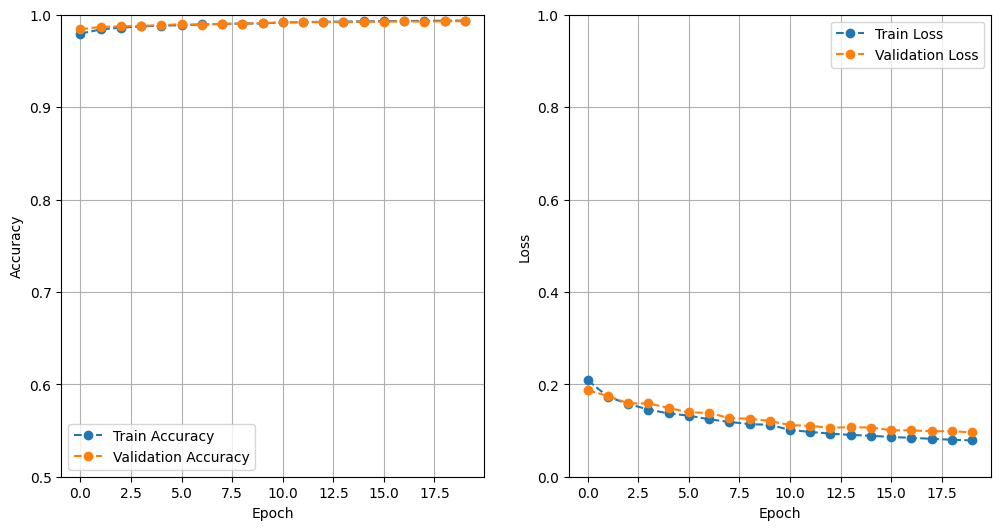

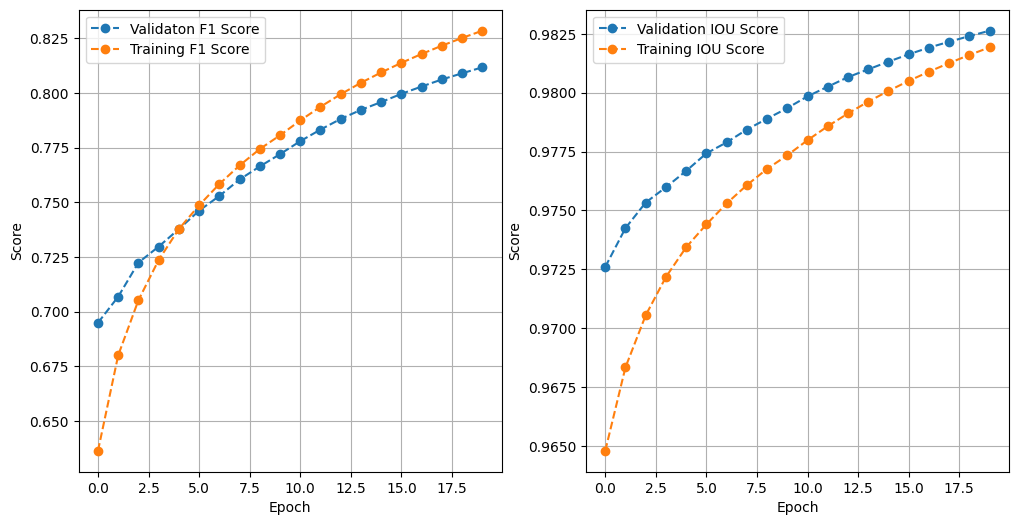

In [ ]:
# %%

if model_training:
    train(
        model,
        images_augmented,
        labels_augmented,
        images_validation,
        labels_validation,
        loss_func=BCEIoULoss(),
        batch_size=4,
        learning_rate=2e-4,
        epochs=20,
        model_validation=model_validation,
        cuda_available=cuda_available,
        path_model=path_model,
    )

if model_loading:
    # Load the model from your Google Drive or local file system
    checkpoint = torch.load(path_model)
    model.load_state_dict(checkpoint["model_state_dict"])

In [ ]:
# %%

submission = submission_creating(
    model, path_testing, training_resize, testing_resize, cuda_available
)

100%|██████████| 5/5 [00:00<00:00,  6.68it/s]


In [ ]:
# %%

np.savetxt("submit.csv", submission, delimiter=",", fmt="%s")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1218894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0033040235..1.0847623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0004824306..1.075873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1066992].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0760508].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3341668].


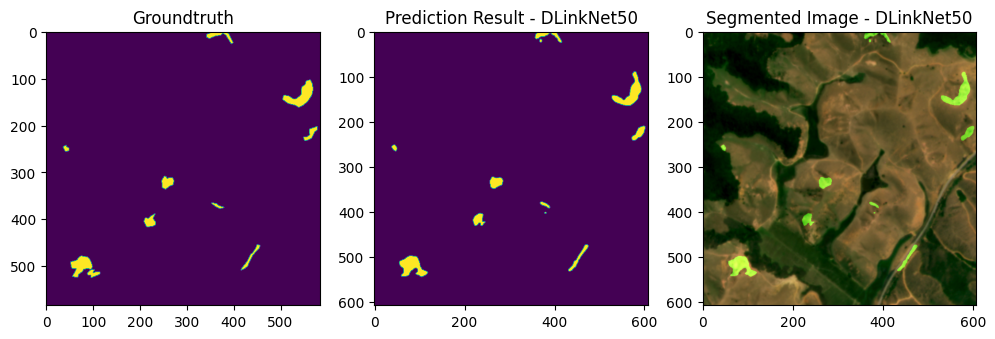

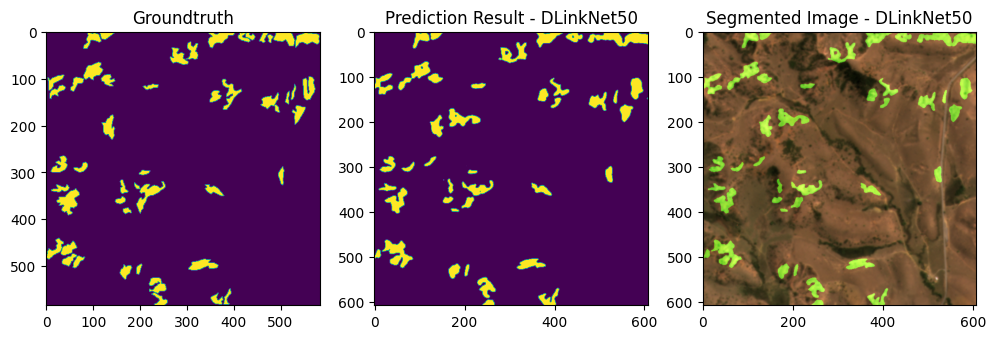

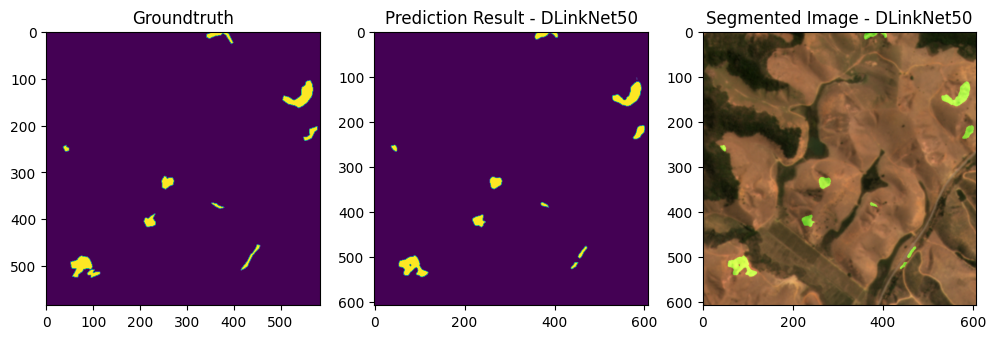

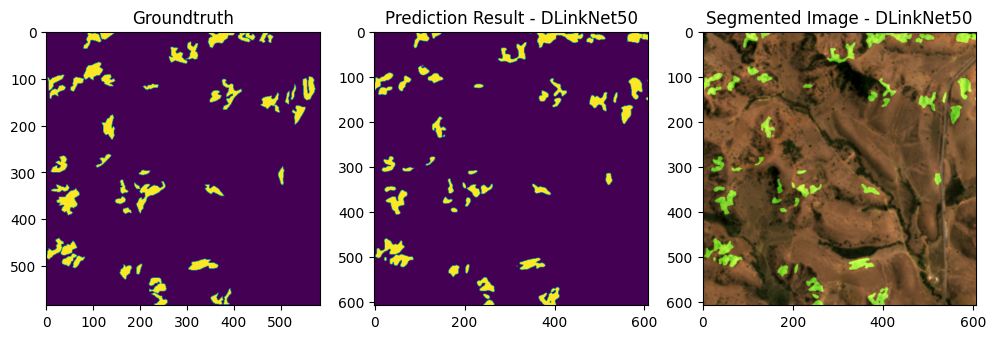

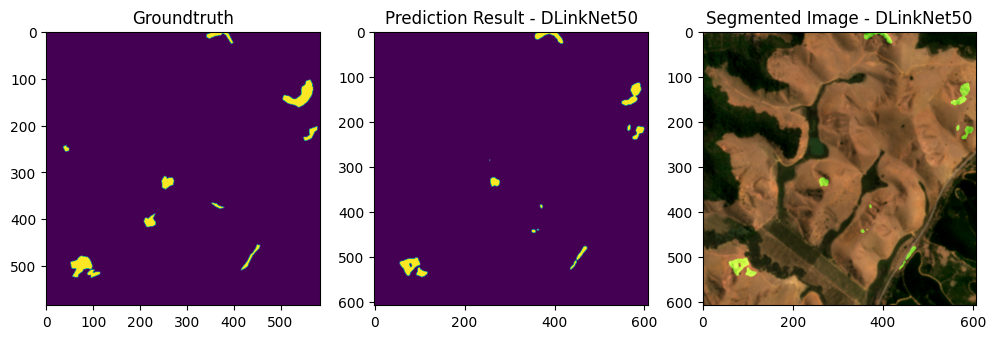

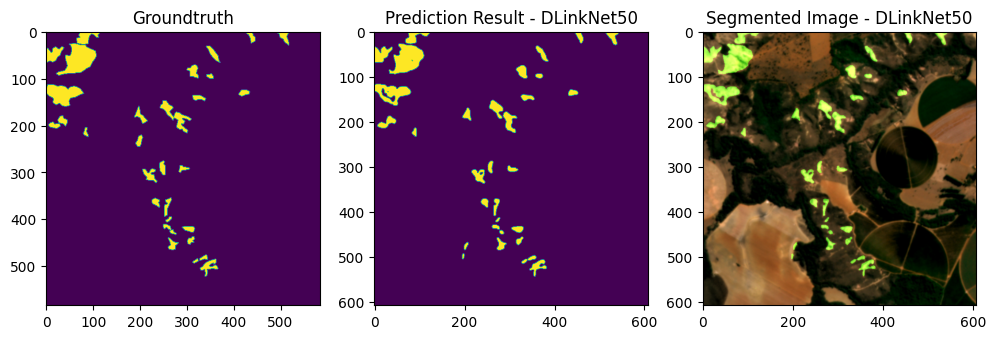

In [ ]:
# %%

for aux in range(747, 753):
    test(path_testing, aux, model, cuda_available)